<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/ew_distributions_AHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
Q20# !pip install netCDF4
import xarray as xr
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt
import datetime
import glob
from tqdm import tqdm

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
cb_centerlines = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp').to_crs(3857)

In [9]:
merit_centerlines = gpd.read_file('/content/drive/MyDrive/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_bugfix1.shp').to_crs(3857)

In [10]:
ew_pts1 = gpd.read_file('/content/drive/MyDrive/platte_pts_10000m.shp')[['iindex', 'geometry']]
ew_circles1 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')[['iindex', 'geometry']]

ew_pts2 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_20250918.shp')[['iindex', 'geometry']]
ew_circles2 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250918.shp')[['iindex', 'geometry']]

ew_pts3 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_extra.shp')[['iindex', 'geometry']]
ew_circles3 = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_extra.shp')[['iindex', 'geometry']]


ew_pts = pd.concat([ew_pts1, ew_pts2, ew_pts3])
ew_pts = gpd.GeoDataFrame(ew_pts, geometry=ew_pts.geometry, crs=4326).to_crs(3857)

ew_circles = pd.concat([ew_circles1, ew_circles2, ew_circles3])
ew_circles = gpd.GeoDataFrame(ew_circles, geometry=ew_circles.geometry).to_crs(3857)
ew_pts = ew_pts.loc[(ew_pts.iindex.isin(ew_circles.iindex)) & (ew_pts.iindex != 30618)]

ew_circles['riv_length'] = ew_circles.apply(lambda x: gpd.sjoin(cb_centerlines, gpd.GeoDataFrame(geometry=[x.geometry], crs=3857)).length.sum(), axis=1)

ew_pts = pd.merge(ew_pts, ew_circles[['iindex', 'riv_length']])
ew_pts = ew_pts.to_crs(3857).sjoin_nearest(merit_centerlines, distance_col='distance_merit')[['iindex', 'geometry', 'riv_length', 'COMID', 'distance_merit', 'order']]

ew_pts = ew_pts.sjoin_nearest(cb_centerlines[['NewSO', 'geometry']], distance_col='distance_cb').drop_duplicates('iindex')

ew_pts

,iindex,geometry,riv_length,COMID,distance_merit,order,index_right,NewSO,distance_cb
0,38577,POINT (-11690505.247 4811857.209),81.082801,74038452,53.288151,4,4997,9,10.629683
1,33809,POINT (-11685635.215 4835085.32),136.538532,74038417,24.918905,4,2998,9,1.070429
2,34632,POINT (-11688434.826 4823704.536),125.759812,74038438,24.136813,4,3995,9,4.604104
3,40608,POINT (-11680394.88 4846335.545),122.568220,74038395,593.019014,4,2002,9,5.646844
4,37091,POINT (-11673614.76 4855615.592),302.318549,74038375,274.707401,4,1000,9,7.395028
...,...,...,...,...,...,...,...,...,...
472,107328,POINT (-10837835.026 5073919.205),937.874503,74029224,9.738052,5,223574,10,2.273456
473,244511,POINT (-11080725.027 4965503.779),1195.506855,74029167,3.425225,6,162885,12,2.794537
474,245153,POINT (-11083844.976 4964870.754),1217.410395,74030651,194.248106,2,368438,12,7.007301
475,246043,POINT (-10718194.959 5055774.457),496.596308,74029691,19.119825,5,130752,10,5.015099


In [11]:
# years = [2018, 2019, 2021, 2022, 2023, 2024]
# months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_list = []

files = glob.glob('/content/drive/MyDrive/effwidth_results/all_sites/*20250928.csv')
for f in tqdm(files):
    df_list.append(pd.read_csv(f))

files = glob.glob('/content/drive/MyDrive/effwidth_results/gage_sites/*g*_2025092*.csv')
for f in tqdm(files):
    df_list.append(pd.read_csv(f))

widths = pd.concat(df_list)

widths['date'] = widths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
widths['date'] = pd.to_datetime(widths.date)

widths = pd.merge(widths, ew_pts, on='iindex', how='left')

widths

100%|██████████| 14/14 [00:00<00:00, 42.49it/s]


,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,date,geometry,riv_length,COMID,distance_merit,order,index_right,NewSO,distance_cb
0,0,S2A_13TGF_20240103_0_L2A,9803,308,308,79,0,308,0,58,9,2024-01-03,POINT (-11408584.956 5002072.656),287.446706,74029423.0,38.036051,5.0,39780.0,11.0,5.595291
1,1,S2A_13TGF_20240103_0_L2A,13320,765,765,171,0,743,0,90,16,2024-01-03,POINT (-11398675.129 5005766.481),460.710985,74029423.0,305.704761,5.0,122974.0,11.0,1.232603
2,2,S2A_13TGF_20240103_0_L2A,13696,758,758,154,0,200,0,90,8,2024-01-03,POINT (-11402435.244 5004680.728),448.358320,74029423.0,116.117299,5.0,123267.0,11.0,5.287914
3,3,S2A_13TGF_20240103_0_L2A,7591,1455,1455,260,0,838,0,124,9,2024-01-03,POINT (-11418684.899 5000034.786),621.348928,74029425.0,56.452354,5.0,40556.0,11.0,5.024024
4,4,S2A_13TGF_20240103_0_L2A,36643,1456,1456,281,55,864,0,124,10,2024-01-03,POINT (-11368854.808 5059048.937),646.856009,74029266.0,9.719406,5.0,104367.0,11.0,12.464640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229172,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,2024-12-19,POINT (-10767564.986 5136958.447),633.810677,74023339.0,22.942618,5.0,251716.0,10.0,4.243144
229173,448,S2A_14TQL_20241020_0_L2A,246043,763,763,196,0,0,0,90,12,2024-10-20,POINT (-10718194.959 5055774.457),496.596308,74029691.0,19.119825,5.0,130752.0,10.0,5.015099
229174,449,S2A_14TPL_20240213_0_L2A,107328,3325,0,0,0,0,0,186,0,2024-02-13,POINT (-10837835.026 5073919.205),937.874503,74029224.0,9.738052,5.0,223574.0,10.0,2.273456
229175,450,S2A_14TNL_20241105_0_L2A,259030,308,0,0,0,0,0,58,0,2024-11-05,POINT (-10991695.037 5017054.391),288.056908,74029356.0,17.759166,4.0,301427.0,10.0,4.650442


In [12]:
widths['sat_width_m'] = widths.n_river * 100 / widths.riv_length
widths['fraction_cloud'] = widths.n_cloud / widths.n_pixels
widths['fraction_snow'] = widths.n_snow / widths.n_pixels
widths['fraction_edgeriver'] = widths.n_edgeriver / widths.n_edge

widths_filtered = widths.copy()
widths_filtered = widths_filtered.loc[widths_filtered.iindex != 30618]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_cloud < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_snow < 0.2]
widths_filtered = widths_filtered.loc[((widths_filtered.n_cloud - widths_filtered.n_cloudriver) / widths_filtered.n_valid) < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_edgeriver < 0.4]
widths_filtered = widths_filtered.loc[widths_filtered.n_edge < widths_filtered.n_river]
widths_filtered.COMID = np.uint32(widths_filtered.COMID)

In [75]:
Q2024 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc')
Q2023 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2023.nc')
Q2022 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2022.nc')
Q2021 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2021.nc')
Q2020 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2020.nc')
Q2019 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2019.nc')
Q2018 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2018.nc')

In [76]:
COMID_arr = widths_filtered.COMID.unique()

Q2024 = Q2024.sel(rivid=COMID_arr)
Q2023 = Q2023.sel(rivid=COMID_arr)
Q2022 = Q2022.sel(rivid=COMID_arr)
Q2021 = Q2021.sel(rivid=COMID_arr)
Q2020 = Q2020.sel(rivid=COMID_arr)
Q2019 = Q2019.sel(rivid=COMID_arr)
Q2018 = Q2018.sel(rivid=COMID_arr)

all_Q = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')

/tmp/ipython-input-2254169007.py:11: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  all_Q = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')


In [90]:
Qdf = all_Q.to_dataframe()\
    .reset_index()\
    .drop('nerr', axis=1)\
    .drop_duplicates(['time', 'rivid'])\
    .rename(columns={'time': 'date', 'rivid': 'COMID'})

Qdf.COMID = np.uint32(Qdf.COMID)

Qdf = Qdf.set_index(['date', 'COMID'])

Qdf

Qout      Qout_err           crs           lon  \
date       COMID                                                           
2018-01-01 74029238   1.312146           NaN           NaN  9.969210e+36   
           74022645   0.043005           NaN           NaN  9.969210e+36   
           74022532   3.911738           NaN           NaN  9.969210e+36   
           74022647   2.445383           NaN           NaN  9.969210e+36   
           74022533  14.620130           NaN           NaN  9.969210e+36   
...                        ...           ...           ...           ...   
2024-12-31 74038444   0.041568  9.969210e+36 -2.147484e+09  9.969210e+36   
           74022745   1.940418  9.969210e+36 -2.147484e+09  9.969210e+36   
           74029167   5.046213  9.969210e+36 -2.147484e+09  9.969210e+36   
           74030651   0.003685  9.969210e+36 -2.147484e+09  9.969210e+36   
           74023385   1.435470  9.969210e+36 -2.147484e+09  9.969210e+36   

                              lat  
date       COMID                   
2018-01-01 74029238  9.969210e+36  
           74022645  9.969210e+36  
           74022532  9.969210e+36  
           74022647  9.969210e+36  
           74022533  9.969210e+36  
...                           ...  
2024-12-31 74038444  9.969210e+36  
           74022745  9.969210e+36  
           74029167  9.969210e+36  
           74030651  9.969210e+36  
           74023385  9.969210e+36  

[718517 rows x 5 columns]

In [122]:
widths_filtered.NewSO.unique()

array([11.,  9., 12.,  7.,  6., 10.,  8.])

In [144]:
Qw = widths_filtered.set_index(['date', 'COMID']).join(Qdf)

Qw_reach = Qw.groupby(['COMID', 'date']).agg(
    mean_width = ('sat_width_m', lambda x: x.mean()),
    median_width = ('sat_width_m', lambda x: x.median()),
    min_width = ('sat_width_m', lambda x: x.min()),
    max_width = ('sat_width_m', lambda x: x.max()),
    n_meas = ('sat_width_m', lambda x: x.count()),
    Q_cms = ('Qout', lambda x: x.mean())
).reset_index()

Qw_reach
#  ['Q_percentile'] = Qw_reach.groupby('COMID')['']

,COMID,date,mean_width,median_width,min_width,max_width,n_meas,Q_cms
0,74022503,2018-02-13,67.210955,67.210955,67.210955,67.210955,1,1.517580
1,74022503,2018-02-28,71.313032,71.313032,71.313032,71.313032,1,1.992667
2,74022503,2018-03-20,65.633233,65.633233,65.633233,65.633233,1,11.637224
3,74022503,2018-05-04,76.598400,76.598400,76.598400,76.598400,1,4.322105
4,74022503,2018-05-24,99.238710,99.238710,99.238710,99.238710,1,6.870263
...,...,...,...,...,...,...,...,...
56451,74038417,2023-06-27,22.447015,22.447015,22.447015,22.447015,2,0.292305
56452,74038438,2020-03-09,24.650164,24.650164,24.650164,24.650164,1,5.045885
56453,74038444,2018-03-03,26.534806,26.534806,26.534806,26.534806,1,0.021729
56454,74038465,2023-03-04,43.350443,43.350443,43.350443,43.350443,1,3.881728


In [149]:
Qw_reach = pd.merge(Qw_reach, ew_pts[['COMID', 'NewSO']], on='COMID', how='left').set_index(['COMID', 'date'])

In [150]:
Qw_reach['Q_percentile'] = Qw_reach.groupby('COMID')['Q_cms'].rank(pct=True)

decile_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
quintile_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
quartile_bins = [0, 0.25, 0.5, 0.75, 1.0]

Qw_reach['decile'] = Qw_reach.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=decile_bins, labels=False)
)
Qw_reach['quintile'] = Qw_reach.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=quintile_bins, labels=False)
)
Qw_reach['quartile'] = Qw_reach.groupby('COMID')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=quartile_bins, labels=False)
)

Qw_reach

mean_width  median_width   min_width   max_width  n_meas  \
COMID    date                                                                   
74022503 2018-02-13   67.210955     67.210955   67.210955   67.210955       1   
         2018-02-28   71.313032     71.313032   71.313032   71.313032       1   
         2018-03-20   65.633233     65.633233   65.633233   65.633233       1   
         2018-05-04   76.598400     76.598400   76.598400   76.598400       1   
         2018-05-24   99.238710     99.238710   99.238710   99.238710       1   
...                         ...           ...         ...         ...     ...   
74038438 2020-03-09   24.650164     24.650164   24.650164   24.650164       1   
         2020-03-09   24.650164     24.650164   24.650164   24.650164       1   
74038444 2018-03-03   26.534806     26.534806   26.534806   26.534806       1   
74038465 2023-03-04   43.350443     43.350443   43.350443   43.350443       1   
         2023-03-09  109.013615    109.013615  109.013615  109.013615       1   

                         Q_cms  NewSO  Q_percentile  decile  quintile  \
COMID    date                                                           
74022503 2018-02-13   1.517580     11      0.308511       3         1   
         2018-02-28   1.992667     11      0.377660       3         1   
         2018-03-20  11.637224     11      0.962766       9         4   
         2018-05-04   4.322105     11      0.760638       7         3   
         2018-05-24   6.870263     11      0.904255       9         4   
...                        ...    ...           ...     ...       ...   
74038438 2020-03-09   5.045885      9      0.750000       7         3   
         2020-03-09   5.045885      9      0.750000       7         3   
74038444 2018-03-03   0.021729      9      1.000000       9         4   
74038465 2023-03-04   3.881728      9      1.000000       9         4   
         2023-03-09   0.699449      9      0.500000       4         2   

                     quartile  
COMID    date                  
74022503 2018-02-13         1  
         2018-02-28         1  
         2018-03-20         3  
         2018-05-04         3  
         2018-05-24         3  
...                       ...  
74038438 2020-03-09         2  
         2020-03-09         2  
74038444 2018-03-03         3  
74038465 2023-03-04         3  
         2023-03-09         1  

[97881 rows x 11 columns]

In [155]:
orders = Qw_reach.sort_values('NewSO')['NewSO'].unique()
orders

array([ 6,  7,  8,  9, 10, 11, 12])

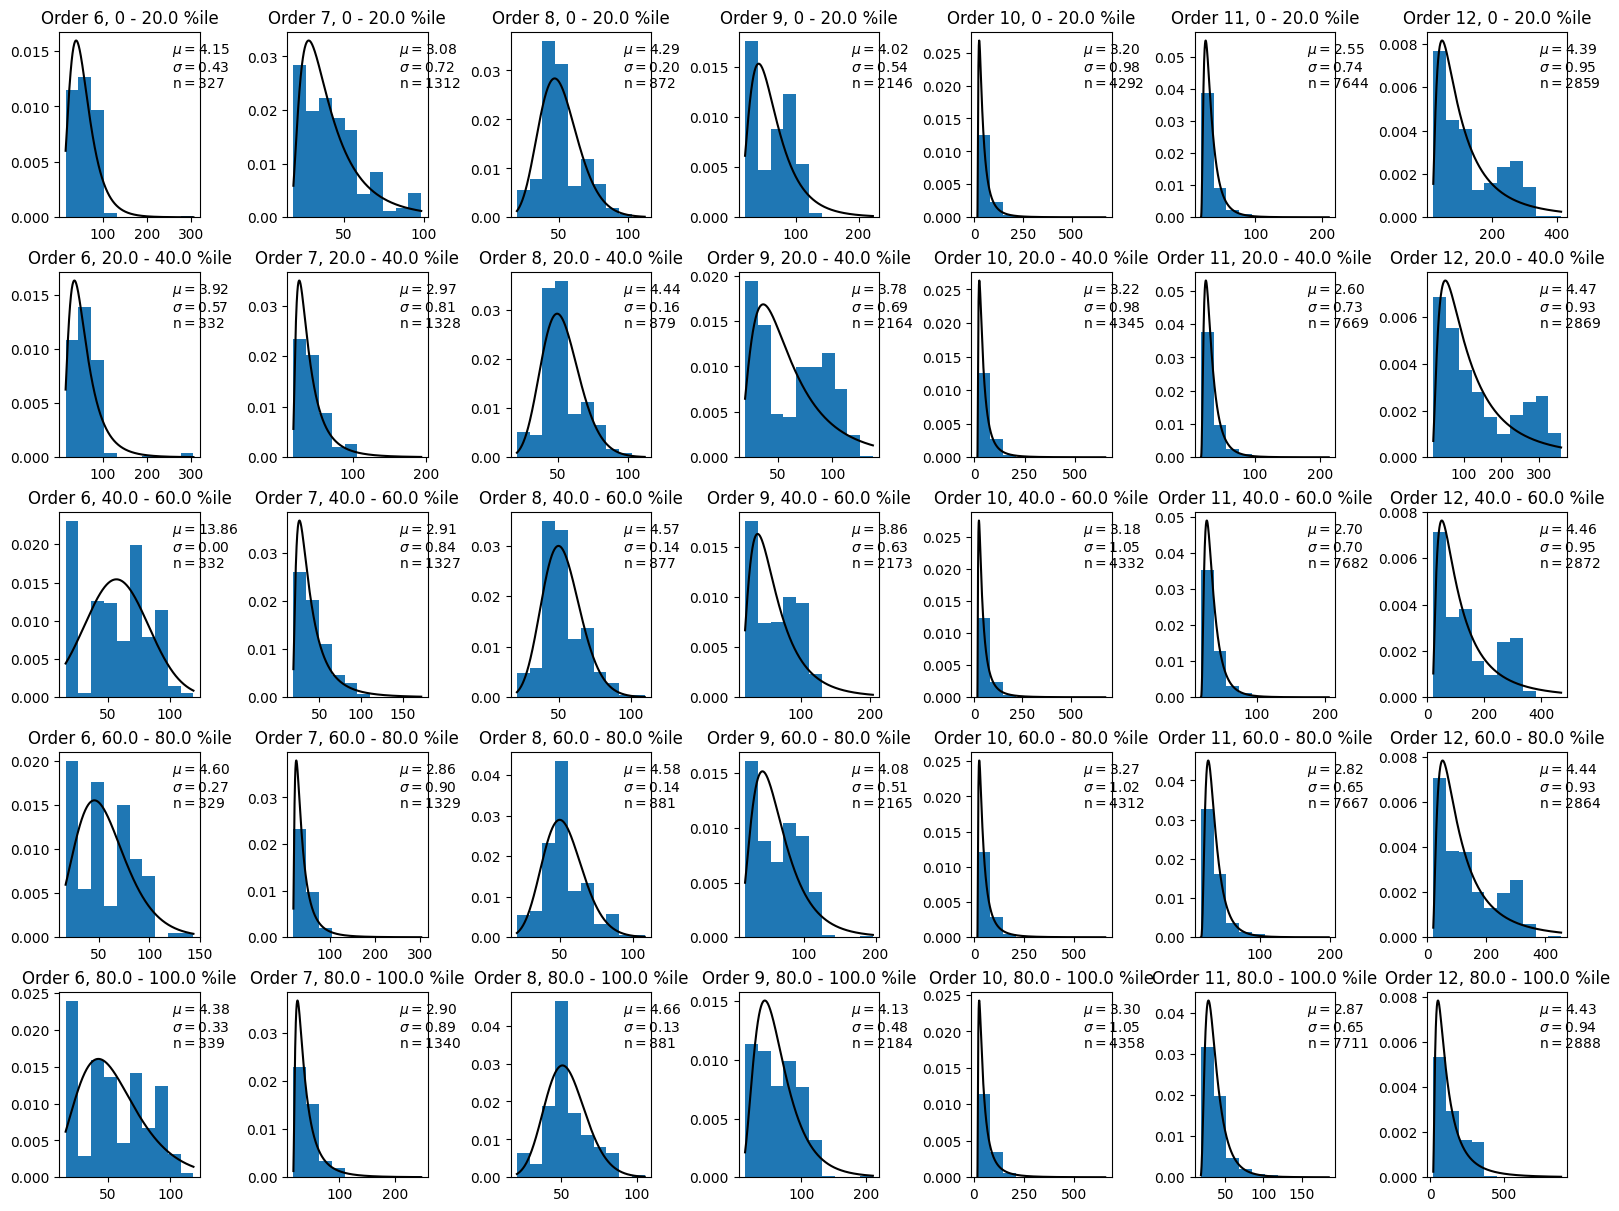

In [169]:
fig, axs = plt.subplots(5, 7, figsize=(16, 12), constrained_layout=True)

for q in range(len(quintile_bins) - 1):
    for o in range(len(orders)):
        order = orders[o]
        ax = axs[q, o]
        df = Qw_reach.loc[(Qw_reach.NewSO == order) & (Qw_reach.quintile == q)]

        x = np.linspace(min(df.mean_width), max(df.mean_width), 1000)

        shape, loc, scale = lognorm.fit(df.mean_width)
        sigma = shape
        mu = np.log(scale)
        pdf_fitted = lognorm.pdf(x, shape, scale=scale, loc=loc)


        ax.hist(df.mean_width, density=True)
        ax.plot(x, pdf_fitted, color='black')

        param_label = '\n'.join((
            r'$\mu=%.2f$' % (mu, ),
            r'$\sigma=%.2f$' % (sigma, ),
            r'$\mathrm{n}=%.0f$' % (len(df) )))
        ax.text(0.8, 0.95, param_label, transform=ax.transAxes, verticalalignment='top')
        ax.set_title(f'Order {order}, {100 * quintile_bins[q]} - {100 * quintile_bins[q + 1]} %ile')

In [165]:
from scipy.stats import lognorm, linregress


In [105]:
medians = widths_filtered.groupby('iindex')['sat_width_m'].agg('median')

In [103]:
from scipy.stats import gaussian_kde

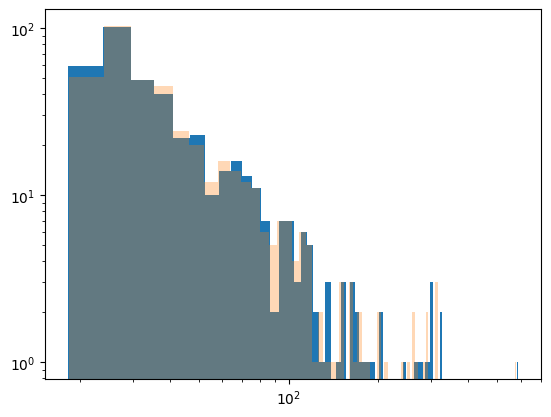

In [107]:
kde = gaussian_kde(medians)
x_kde = np.linspace(min(medians), max(medians), 100)
kde_values = kde(x_kde)


fig, ax = plt.subplots()
# ax.plot(x_kde, kde_values)
ax.hist(medians, bins=100)
ax.hist(means, bins=100, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

## sanity check... aggregating across stream orders looks like a pareto!!!!!!

In [ ]:
ordermeds = widths_filtered.groupby(['iindex', 'NewSO'])['sat_width_m'].agg('median')

,,sat_width_m
iindex,NewSO,
692,11,92.335726
932,12,235.343519
1082,7,31.575887
1877,7,41.712206
3018,8,31.602672
...,...,...
254274,10,84.373380
255389,12,273.521623
255765,10,204.985763
